In [1]:
import pandas as pd
import numpy as np
import os

# Load the dataset we created in the previous notebook
data_path = '../data/btc_usd_h4_features.csv'
df = pd.read_csv(data_path, index_col='timestamp', parse_dates=True)

print("Data loaded successfully.")
display(df.head())

Data loaded successfully.


,open,high,low,close,volume,ichimoku_senkou_span_a,ichimoku_senkou_span_b,ichimoku_tenkan_sen,ichimoku_kijun_sen,ichimoku_chikou_span,...,BBB_20_2.0,BBP_20_2.0,ATRr_14,ADX_14,DMP_14,DMN_14,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-10-26 12:00:00,9218.63,9435.76,9045.92,9188.98,99.655543,8156.0825,8136.85,8865.08,8831.335,9154.99,...,38.711030,0.877206,320.684784,48.068949,50.337892,13.708803,1684.348333,0,1,0
2019-10-26 16:00:00,9194.29,9234.36,8905.35,9003.59,102.548898,8156.0825,8129.61,8895.84,8831.335,9099.04,...,39.892238,0.789875,321.279443,48.158986,46.655811,15.831270,1747.121667,0,1,0
2019-10-26 20:00:00,9003.07,9280.85,9001.99,9231.81,38.275267,8156.0825,8112.96,8963.99,8831.335,9098.08,...,40.615307,0.823234,318.249481,48.305935,44.779151,14.840424,1852.043333,0,1,0
2019-10-27 00:00:00,9232.69,9364.63,9100.19,9132.38,44.661409,8168.7375,8112.96,9310.44,8831.335,9107.98,...,40.711207,0.765000,314.405946,48.559202,43.992316,13.948855,1776.460000,0,1,0
2019-10-27 04:00:00,9127.71,9199.00,9077.85,9143.12,22.325593,8131.4150,8112.96,9450.71,8831.335,9211.77,...,40.397292,0.742647,300.601946,48.693015,42.725888,14.078142,1714.025000,0,1,0


In [2]:
def define_target(df, profit_pct=0.03, loss_pct=0.015, lookahead_candles=30):
    """
    Creates the target variable for the ML model.
    - 1: BUY (price went up by profit_pct before going down by loss_pct)
    - -1: SELL (price went down by profit_pct before going up by loss_pct)
    - 0: HOLD (neither happened within the lookahead window)
    """
    df['target'] = 0
    
    for i in range(len(df) - lookahead_candles):
        entry_price = df['close'].iloc[i]
        
        # Define the price window to look into the future
        future_window = df['close'].iloc[i+1 : i+1+lookahead_candles]
        
        take_profit_buy = entry_price * (1 + profit_pct)
        stop_loss_buy = entry_price * (1 - loss_pct)
        
        take_profit_sell = entry_price * (1 - profit_pct)
        stop_loss_sell = entry_price * (1 + loss_pct)
        
        # Check for BUY signal outcome
        # Did the price hit our take profit before our stop loss?
        buy_profit_hit_time = future_window[future_window >= take_profit_buy].first_valid_index()
        buy_loss_hit_time = future_window[future_window <= stop_loss_buy].first_valid_index()
        
        if buy_profit_hit_time is not None and (buy_loss_hit_time is None or buy_profit_hit_time < buy_loss_hit_time):
            df['target'].iloc[i] = 1 # BUY
            continue

        # Check for SELL signal outcome
        # Did the price hit our take profit before our stop loss?
        sell_profit_hit_time = future_window[future_window <= take_profit_sell].first_valid_index()
        sell_loss_hit_time = future_window[future_window >= stop_loss_sell].first_valid_index()
            
        if sell_profit_hit_time is not None and (sell_loss_hit_time is None or sell_profit_hit_time < sell_loss_hit_time):
            df['target'].iloc[i] = -1 # SELL
            continue
            
    return df

print("Target definition function created.")

Target definition function created.


Target labeling complete.

Target Distribution:
target
 1    4720
-1    4083
 0    3977
Name: count, dtype: int64


/var/folders/hl/ngkjhrhj6gv8_hgfff2pwfl40000gn/T/ipykernel_29887/3846611153.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'].iloc[i] = 1 # BUY
/var/folders/hl/ngkjhrhj6gv8_hgfff2pwfl40000gn/T/ipykernel_29887/3846611153.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'].iloc[i] = 1 # BUY
/var/folders/hl/ngkjhrhj6gv8_hgfff2pwfl40000gn/T/ipykernel_29887/3846611153.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

<Axes: title={'center': 'Distribution of Target Labels (0=Hold, 1=Buy, -1=Sell)'}, xlabel='target'>

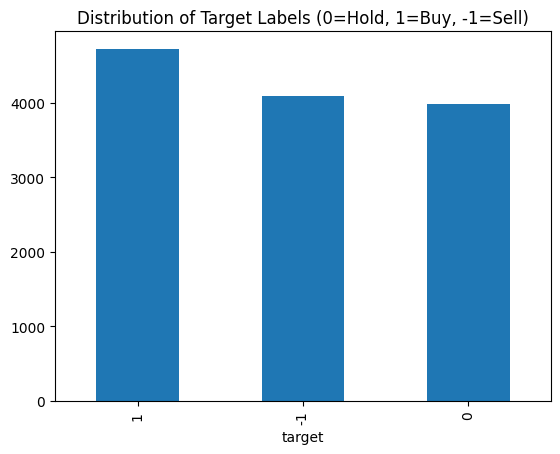

In [3]:
# Apply the function to our DataFrame
# This can take a minute or two to run as it's iterating through the data
labeled_df = define_target(df, profit_pct=0.03, loss_pct=0.015, lookahead_candles=30)

print("Target labeling complete.")

# Analyze the distribution of our targets
target_distribution = labeled_df['target'].value_counts()
print("\nTarget Distribution:")
print(target_distribution)

# Plot the distribution
target_distribution.plot(kind='bar', title='Distribution of Target Labels (0=Hold, 1=Buy, -1=Sell)')

In [4]:
# Save the final labeled DataFrame for the model training stage
output_path = '../data/btc_usd_h4_labeled.csv'
labeled_df.to_csv(output_path)

print(f"Labeled data saved successfully to: {output_path}")

Labeled data saved successfully to: ../data/btc_usd_h4_labeled.csv
